In [27]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [19]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Autoregressive forecaster with custom predictors

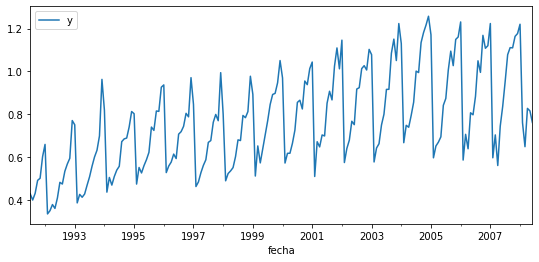

In [20]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax, label='y')
ax.legend();

In [21]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

In [22]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor=LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )
forecaster.fit(y=data_train)
forecaster

<class 'skforecast.ForecasterAutoregCustom.ForecasterAutoregCustom'> 
Regressor: LinearRegression() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1993-03-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

In [24]:
forecaster = ForecasterAutoregCustom(
                    regressor=LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )
forecaster.fit(y=data_train)
forecaster

<class 'skforecast.ForecasterAutoregCustom.ForecasterAutoregCustom'> 
Regressor: LinearRegression() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

Test error (mse): 0.024334075665271456


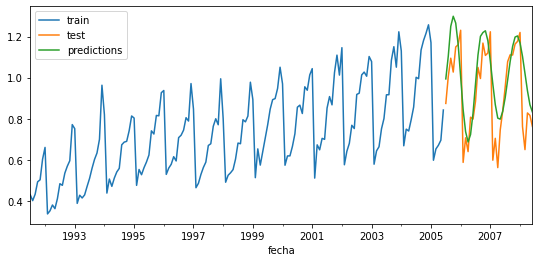

In [5]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 4
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:18<00:00, 18.72s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric,max_depth,n_estimators
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.025273,10,100
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.025815,5,50
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.026016,5,100
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.026035,10,50


In [7]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.53877237 0.1176578  0.04912726 0.02084317 0.03449704 0.01707262
 0.03820119 0.01513322 0.01789241 0.10839113 0.04241179]


In [8]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]

steps = 36
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Number of observations used for training or as initial window: 95
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.06468538]


In [9]:
print(len(predicciones_backtest), predicciones_backtest)

109 1999-06-01    0.625475
1999-07-01    0.546497
1999-08-01    0.648590
1999-09-01    0.697900
1999-10-01    0.769413
                ...   
2008-02-01    1.069415
2008-03-01    0.930378
2008-04-01    0.753936
2008-05-01    0.577290
2008-06-01    0.562382
Freq: MS, Name: pred, Length: 109, dtype: float64


In [10]:
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)
print(len(predictions_1), predictions_1)
print("")
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps])
print(len(predictions_2), predictions_2)
print("")
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2])
print(len(predictions_3), predictions_3)
print("")
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3])
print(len(predictions_4), predictions_4)
print("")

36 1999-06-01    0.625475
1999-07-01    0.546497
1999-08-01    0.648590
1999-09-01    0.697900
1999-10-01    0.769413
1999-11-01    0.805157
1999-12-01    0.891066
2000-01-01    0.863153
2000-02-01    0.796071
2000-03-01    0.739149
2000-04-01    0.641381
2000-05-01    0.607793
2000-06-01    0.559542
2000-07-01    0.552087
2000-08-01    0.588981
2000-09-01    0.634434
2000-10-01    0.692084
2000-11-01    0.795750
2000-12-01    0.880776
2001-01-01    0.900889
2001-02-01    0.873682
2001-03-01    0.795952
2001-04-01    0.717156
2001-05-01    0.638772
2001-06-01    0.568637
2001-07-01    0.531007
2001-08-01    0.540006
2001-09-01    0.583698
2001-10-01    0.655072
2001-11-01    0.750733
2001-12-01    0.834921
2002-01-01    0.892428
2002-02-01    0.901658
2002-03-01    0.861888
2002-04-01    0.789657
2002-05-01    0.698116
Freq: MS, Name: pred, dtype: float64

36 2002-06-01    0.629288
2002-07-01    0.519130
2002-08-01    0.704213
2002-09-01    0.777716
2002-10-01    0.947477
2002-11-01   

### Autoreg + 1 exogenous predictor
<br>

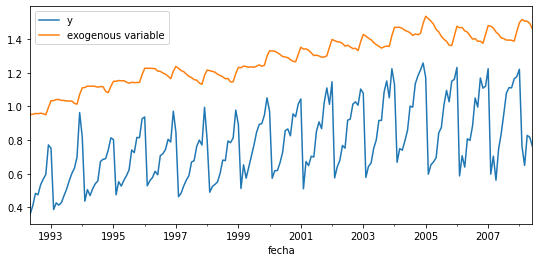

In [11]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Exogenous variable
# ==============================================================================
data_exog = data.rolling(window=10, closed='right').mean() + 0.5
data_exog = data_exog[10:]
data = data[10:]

fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax, label='y')
data_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

data_exog_train = data_exog[:-steps]
data_exog_test  = data_exog[-steps:]

Test error (mse): 1.2257131747398872e-29


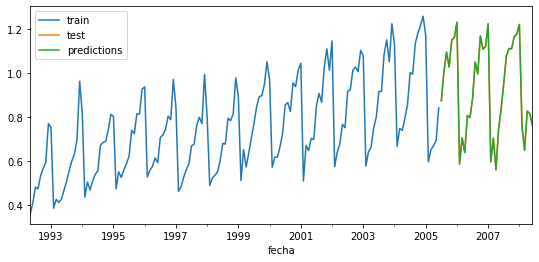

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=data_train, exog=data_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_exog_test)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [13]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        exog        = data_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
               )

# Results grid Search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 4
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:14<00:00, 14.94s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021906,10,50
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.021939,5,100
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.022061,5,50
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022717,10,100


In [14]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]
data_exog_train = data_exog[:-n_test]
data_exog_test  = data_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    exog       = data_exog,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

# Verificar predicciones de backtesting
forecaster.fit(y=data_train, exog=data_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=data_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps], exog=data_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2], exog=data_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3], exog=data_exog_test[steps*3:steps*4])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training or as initial window: 85
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations


True

### Autoregressive + n exogenous predictors
<br>

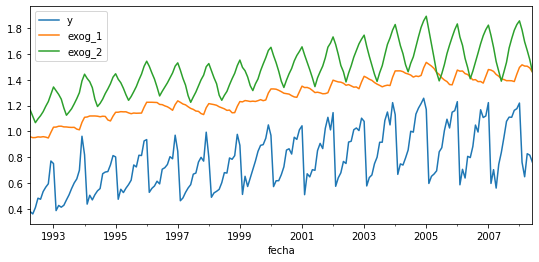

In [15]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [16]:
# Create and fit forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])


# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 1.0435630004440633e-29


In [17]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterAutoregCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 4
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:19<00:00, 19.49s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric,max_depth,n_estimators
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.018828,10,100
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.019937,5,100
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.020056,10,50
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.020165,5,50


## Información de sesión

In [24]:
from sinfo import sinfo
sinfo()

-----
ipykernel   5.4.3
matplotlib  3.3.2
numpy       1.19.2
pandas      1.2.3
sinfo       0.3.1
skforecast  0.1.6
sklearn     0.24.1
tqdm        4.59.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1039-aws-x86_64-with-debian-buster-sid
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-17 17:52
